In [3]:
import matplotlib.pyplot as plt
import cv2  
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import random
import pandas as pd

# Convert images to arrays and store

In [2]:
def load_images(filenames,directory):
    images = []
    for filename in filenames:
        # Use cv2 to read images and convert to RGB
        img = cv2.imread(directory+filename+'.jpg')
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            images.append(img)
    return np.asarray(images)

### Whole train-test dataset

In [3]:
train_csv = pd.read_csv('./COMP90086_2021_Project_train/train.csv')
filenames = np.asarray(train_csv['id'])
# Read training images from folder
train_images = load_images(filenames,'./COMP90086_2021_Project_train/train/')
# Read testing images from folder
test_csv = pd.read_csv('./COMP90086_2021_Project_test/imagenames.csv')
testfilenames = np.asarray(test_csv['id'])
test_images = load_images(testfilenames, './COMP90086_2021_Project_test/test/')
# Store to files, used for future loading
np.save('preprocessed/origin_train_images', train_images)
np.save('preprocessed/origin_test_images', test_images)

### Train validation datasets - for evaluation

In [3]:
def train_validation_split_and_save(file,directory,train_count):
    # Randomly split the whole training data into train images and validation images
    file = file.sample(frac=1)
    train_file = file[:train_count] #Remain train_count images as training
    vali_file = file[train_count:] #Remain train_count images as validation
    train_filenames = np.asarray(train_file['id'])
    vali_filenames = np.asarray(vali_file['id'])
    # Load train and validation images
    train_image = load_images(train_filenames,directory)
    vali_image = load_images(vali_filenames,directory)
    # Save splitted train and vali images and csv
    np.save('preprocessed/trainVali_train_images', train_image)
    np.save('preprocessed/trainVali_vali_images', vali_image)
    train_file.to_csv('preprocessed/train_filenames.csv', index=False) 
    vali_file.to_csv('preprocessed/vali_filenames.csv', index=False)
    
train_csv = pd.read_csv('./COMP90086_2021_Project_train/train.csv')
train_validation_split_and_save(train_csv,'./COMP90086_2021_Project_train/train/',6500)

## Machine learning preprocessing

In [5]:
def ml_processed_images(origin_images, filename, preprocess=None):
    processed_images= []
    for origin_image in origin_images:
        resize_image = cv2.resize(origin_image, (224, 224),interpolation = cv2.INTER_CUBIC)
        resize_image = resize_image.astype(float)
        processed_images.append(resize_image)
    processed_images = np.asarray(processed_images) 
    if preprocess is not None:
        processed_images = preprocess(processed_images)
    np.save('preprocessed/'+filename, processed_images)

### Whole train-test dataset

In [5]:
# Load image arrays
origin_train_images = np.load('preprocessed/origin_train_images.npy')
origin_test_images = np.load('preprocessed/origin_test_images.npy')
ml_processed_images(origin_train_images, 'resnet_preprocess_train', resnet50.preprocess_input)
ml_processed_images(origin_test_images, 'resnet_preprocess_test', resnet50.preprocess_input)

### Train validation datasets - for evaluation

In [6]:
# Load image arrays
origin_trainVali_train_images = np.load('preprocessed/trainVali_train_images.npy')
origin_trainVali_vali_images = np.load('preprocessed/trainVali_vali_images.npy')
ml_processed_images(origin_trainVali_train_images, 'resnet_preprocess_trainvali_train', resnet50.preprocess_input)
ml_processed_images(origin_trainVali_vali_images, 'resnet_preprocess_trainvali_vali', resnet50.preprocess_input)

# Find similar images based on feature extraction and feature matching

## Feature extraction with ResNet

In [7]:
def feature_extraction(images,model,output_layer_name,filename):
    # Use the given model to do feature extraction and save file
    fea_model=Model(model.inputs, model.get_layer(output_layer_name).output)
    features=fea_model.predict(images,verbose=1)
    np.save('preprocessed/'+filename, features)
    return features

### Whole train-test dataset

In [7]:
# Load preprocessed data from files
resnet_train_images = np.load('preprocessed/resnet_preprocess_train.npy')
resnet_test_images = np.load('preprocessed/resnet_preprocess_test.npy')
# Feature extraction
resnet_model_imagenet = ResNet50(weights='imagenet',input_shape = (224,224,3))
resnet_train_fea=feature_extraction(resnet_train_images,resnet_model_imagenet,'avg_pool','resnet_train_fea')
resnet_test_fea=feature_extraction(resnet_test_images,resnet_model_imagenet,'avg_pool','resnet_test_fea')

2021-10-20 12:22:44.373421: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-20 12:22:44.377229: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


1200/1200 [==============================] - 160s 133ms/sample


### Train validation datasets - for evaluation

In [8]:
## Load preprocessed data from files
resnet_trainvali_train_images = np.load('preprocessed/resnet_preprocess_trainvali_train.npy')
resnet_trainvali_vali_images = np.load('preprocessed/resnet_preprocess_trainvali_vali.npy')
resnet_model_imagenet = ResNet50(weights='imagenet',input_shape = (224,224,3))
resnet_trainvali_train_fea=feature_extraction(resnet_trainvali_train_images,resnet_model_imagenet,'avg_pool','resnet_trainvali_train_fea')
resnet_trainvali_vali_fea=feature_extraction(resnet_trainvali_vali_images,resnet_model_imagenet,'avg_pool','resnet_trainvali_vali_fea')

2021-10-20 20:50:56.386167: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-20 20:50:56.390266: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


1000/1000 [==============================] - 155s 155ms/sample


## Find similar images with KNN and feature matching

In [9]:
'''
Version 3 of finding the most similar image: Applying feature matching (SIFT+FLANN) to 
the most 100 similar image determined by extracted features, from these 100 most similar images, 
based on the number of matched features, find the top 3 most similar images(which may be useful
for later transformation calculation) and predict with the top1 most similar image location.
'''

def test_train_most_similar_v3(trains_fea,tests_fea,filename,train_csv,test_csv,origin_train_images,origin_test_images):
    sift = cv2.SIFT_create()
    # The most similar images indexes 
    # This is for using the top1 most similar image location as prediction
    most_similar_indexes = []
    # This is for finding the real top 3 most similar images
    most_three_similar_indexes = []
    # For each test image's extracted feature, calculate the similarities between it and each train images
    # Store the most similar X images
    for text_image_index in tqdm(range(0,len(tests_fea))):
        test_fea = tests_fea[text_image_index]
        similarities = []
        # The similarities between test_fea and each train_fea
        for train_fea in trains_fea:
            similarity = np.linalg.norm(test_fea-train_fea)
            similarities.append(similarity)
        # Sort the similar images in order
        # E.g. similar_indexes_inorder[0] == most similar image index (in the train.csv) decided by extracted features
        similar_indexes_inorder = sorted(range(len(similarities)), key=lambda k: similarities[k])
        # Compute SIFT keypoints (kp) and descriptors (des) for the test image
        test_image = origin_test_images[text_image_index]             
        test_kp, test_des = sift.detectAndCompute(test_image,None)
        # If the test image does not have enough features, just use the top3 similar images decided by extracted features
        if test_des is None or len(test_des)<=3: 
            most_similar_indexes.append(similar_indexes_inorder[0])
            most_three_similar_indexes.append((similar_indexes_inorder[0],similar_indexes_inorder[1],similar_indexes_inorder[2]))
            continue
        topThreshold = 200
        similar_count = 0
        matched_features_counts = []
        for similar_train_index in similar_indexes_inorder: # Similar images in order
            if similar_count > topThreshold:
                break
            similar_count += 1
            # The similar image
            similar_image=origin_train_images[similar_train_index]
            # Compute SIFT keypoints (kp) and descriptors (des) for the similar image
            similar_kp, similar_des = sift.detectAndCompute(similar_image,None)
            if similar_des is None or len(similar_des)<=3: 
                continue
            # FLANN parameters and initialize
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks=100)   # or pass empty dictionary
            flann = cv2.FlannBasedMatcher(index_params,search_params)

            # Matching test and similar images descriptors using KNN algorithm
            matches = flann.knnMatch(test_des,similar_des,k=2)

            # Store all good matches as per Lowe's Ratio test.
            ratio = 0.6
            good = []
            for m,n in matches:
                if m.distance < ratio*n.distance:
                    good.append(m)

            # Set a condition that at least MIN_MATCH_NUM matches are required to find the object. 
            MIN_MATCH_NUM = 4

            if len(good)> MIN_MATCH_NUM:
                # If enough matches are found, we extract the positions of the matched keypoints in both images. 
                # They are passed to find the perspective transformation. 

                # Estimate homography between two images
                ptsA = np.float32([test_kp[m.queryIdx].pt for m in good]).reshape(-1,1,2)
                ptsB = np.float32([similar_kp[m.trainIdx].pt for m in good]).reshape(-1,1,2)
                H, status = cv2.findHomography(ptsA, 
                                               ptsB, 
                                               cv2.RANSAC, 
                                               ransacReprojThreshold = 5, 
                                               maxIters = 500)
                # Where H is the resulting single-strain matrix.
                # status returns a list of feature points that represent successful matches.
                # ptsA, ptsB are keypoints.   

                matchesMask = status.ravel().tolist()
                # total number of successful matches between two images
                success_match = matchesMask.count(1)
                matched_features_counts.append((success_match,similar_train_index)) 
            else:
                matched_features_counts.append((0,similar_train_index))
        matched_features_counts.sort(key=lambda y: y[0],reverse=True)
        most_similar_indexes.append(matched_features_counts[0][1])
        most_three_similar_indexes.append([matched_features_counts[0][1],matched_features_counts[1][1],matched_features_counts[2][1]])
        assert(len(most_similar_indexes) == text_image_index+1) 
        assert(len(most_three_similar_indexes) == text_image_index+1) 
    most_similar_indexes = np.asarray(most_similar_indexes)
    # Use the most similar image location directly
    test_xy_estimations = []
    for i in range (len(tests_fea)):
        train_target_index = most_similar_indexes[i]
        test_xy_estimations.append((train_csv.loc[train_target_index, 'x'],train_csv.loc[train_target_index, 'y']))
    test_xy_estimations = pd.DataFrame(test_xy_estimations, columns=["x", "y"])
    test_estimations = pd.concat([test_csv, test_xy_estimations], axis=1)
    test_estimations.to_csv('kaggle_submission/'+filename+'.csv', index=False) 
    
    
    most_three_similar_indexes = pd.DataFrame(most_three_similar_indexes, columns=["1", "2","3"])
    test_most_three_similar = pd.concat([test_csv, most_three_similar_indexes], axis=1)
    test_most_three_similar.to_csv('preprocessed/top3Similar_'+filename+'.csv', index=False)

### Whole train-test dataset

In [9]:
# Load file names from csv
test_csv = pd.read_csv('./COMP90086_2021_Project_test/imagenames.csv')
train_csv = pd.read_csv('./COMP90086_2021_Project_train/train.csv')
filenames = np.asarray(train_csv['id'])

In [10]:
origin_train_images = np.load('preprocessed/origin_train_images.npy')
origin_test_images = np.load('preprocessed/origin_test_images.npy')
resnet_train_fea = np.load('preprocessed/resnet_train_fea.npy')
resnet_test_fea = np.load('preprocessed/resnet_test_fea.npy')

In [11]:
test_train_most_similar_v3(resnet_train_fea,resnet_test_fea,'resnet_featureMatchingRanking_200',train_csv,test_csv,origin_train_images,origin_test_images)

100%|█████████████████████████████████████| 1200/1200 [6:33:06<00:00, 19.66s/it]


### Train validation datasets - for evaluation

In [10]:
# Load file names from csv
trainvali_train_csv = pd.read_csv('preprocessed/train_filenames.csv')
trainvali_vali_csv = pd.read_csv('preprocessed/vali_filenames.csv')
train_filenames = np.asarray(trainvali_train_csv['id'])

In [11]:
origin_trainVali_train_images = np.load('preprocessed/trainVali_train_images.npy')
origin_trainVali_vali_images = np.load('preprocessed/trainVali_vali_images.npy')
resnet_trainvali_train_fea = np.load('preprocessed/resnet_trainvali_train_fea.npy')
resnet_trainvali_vali_fea = np.load('preprocessed/resnet_trainvali_vali_fea.npy')

In [12]:
test_train_most_similar_v3(resnet_trainvali_train_fea,resnet_trainvali_vali_fea,'resnet_featureMatchingRanking_200_trainvali',trainvali_train_csv,trainvali_vali_csv,origin_trainVali_train_images,origin_trainVali_vali_images)

100%|█████████████████████████████████████| 1000/1000 [5:18:13<00:00, 19.09s/it]


# Evaluate result on validation dataset

The MAE with Manhattan distance is 9.81


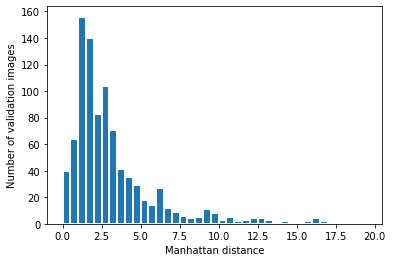

In [11]:
validation_file = pd.read_csv('preprocessed/resnet_featureMatchingRanking_200_trainvali.csv')
validation_filenames = validation_file['id']
trainvali_train_file = pd.read_csv('preprocessed/train_filenames.csv')
trainvali_train_filenames = trainvali_train_file['id']
top3Similar_trainvali = pd.read_csv('preprocessed/top3Similar_resnet_featureMatchingRanking_200_trainvali.csv')
most_similar_indexs = top3Similar_trainvali['1']
# Calculate manhattan distance for each validation image
x_diff = validation_file.iloc[:, 1] - validation_file.iloc[:, 3]
y_diff = validation_file.iloc[:, 2] - validation_file.iloc[:, 4]
manhattan = abs(x_diff) + abs(y_diff)
manhattan_mean = sum(manhattan) / len(manhattan)
print("The MAE with Manhattan distance is {0:.2f}".format(manhattan_mean)) 
bins_list = np.arange(0, 20, 0.5)
plt.hist(manhattan,bins=bins_list, edgecolor='white', linewidth=2)
plt.ylabel("Number of validation images")
plt.xlabel("Manhattan distance")
plt.savefig("evaluation_images/hist.png")

151


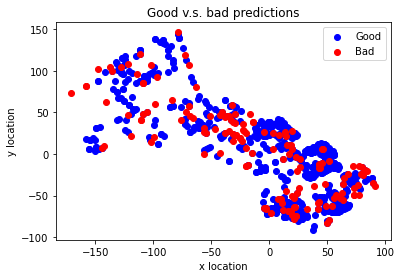

In [22]:
good_pred_x = []
good_pred_y = []
bad_pred_x = []
bad_pred_y = []
for i in range(0,len(manhattan)):
    if (manhattan[i] >= 8):
        bad_pred_x.append(validation_file.iloc[:, 1][i])
        bad_pred_y.append(validation_file.iloc[:, 2][i])
    else:
        good_pred_x.append(validation_file.iloc[:, 1][i])
        good_pred_y.append(validation_file.iloc[:, 2][i])
plt.scatter(good_pred_x,good_pred_y, c='b',label='Good')
plt.scatter(bad_pred_x, bad_pred_y, c='r',label='Bad')
plt.legend(loc='upper right')
plt.title('Good v.s. bad predictions')
plt.xlabel('x location')
plt.ylabel('y location')
plt.show()

The Manhattan distance between ground truth and prediction is 0.60 for this image

Number of successful matches between two images:  111


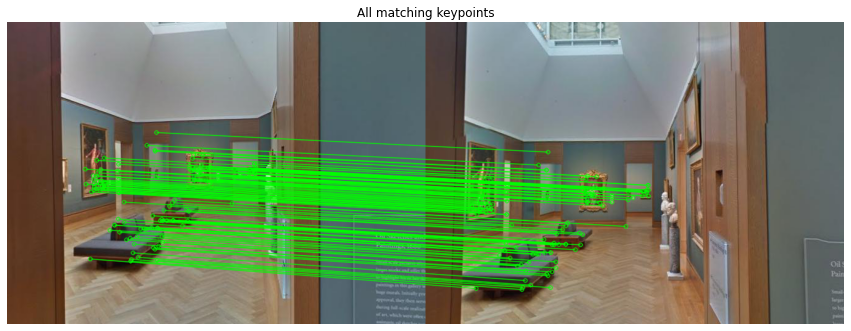

The Manhattan distance between ground truth and prediction is 0.80 for this image

Number of successful matches between two images:  144


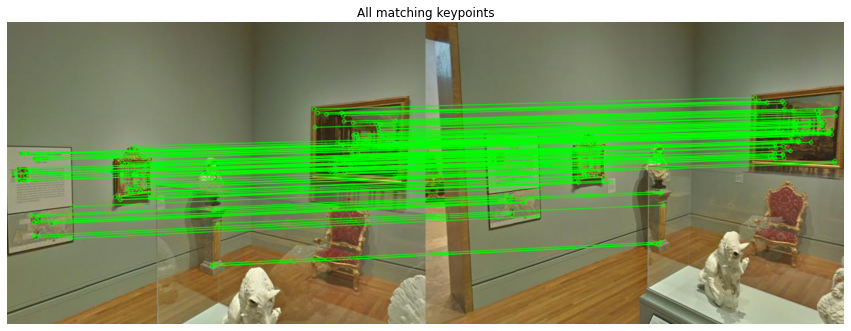

The Manhattan distance between ground truth and prediction is 0.80 for this image

Number of successful matches between two images:  14


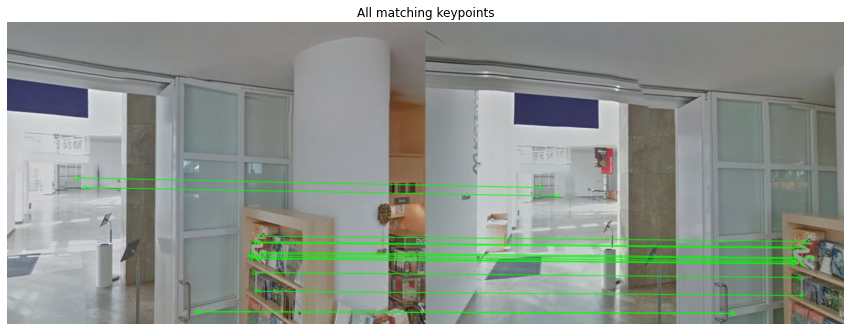

The Manhattan distance between ground truth and prediction is 0.80 for this image

Number of successful matches between two images:  146


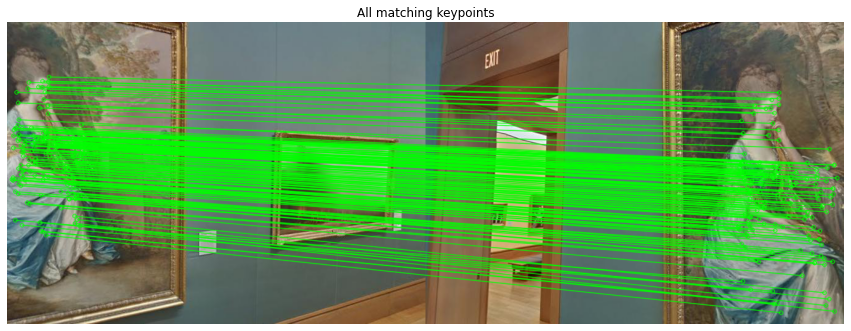

The Manhattan distance between ground truth and prediction is 0.80 for this image

Number of successful matches between two images:  122


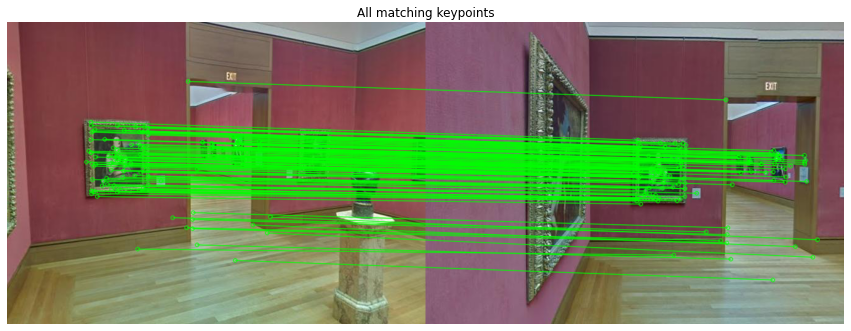

The Manhattan distance between ground truth and prediction is 1.00 for this image

Number of successful matches between two images:  75


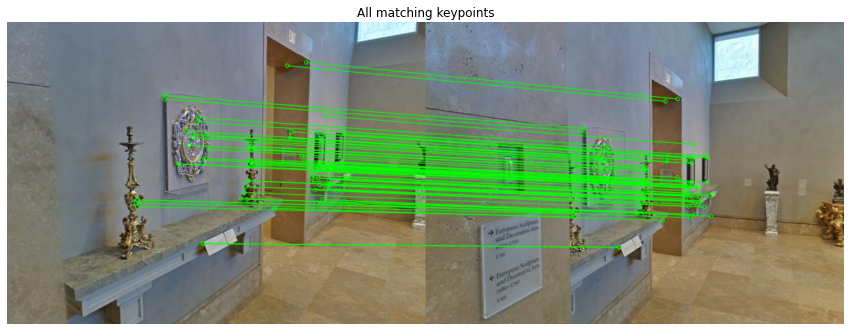

The Manhattan distance between ground truth and prediction is 0.90 for this image

Number of successful matches between two images:  61


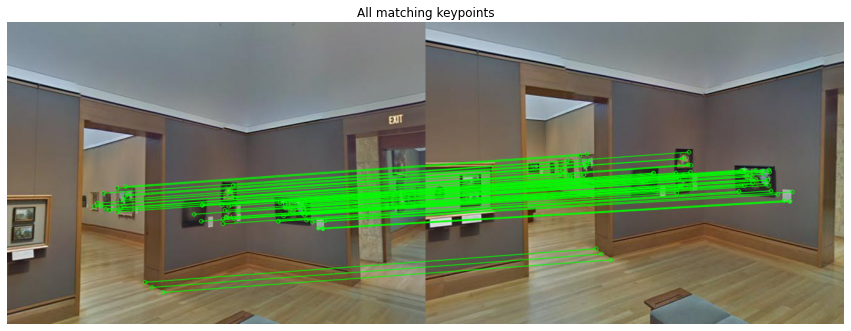

The Manhattan distance between ground truth and prediction is 0.80 for this image

Number of successful matches between two images:  29


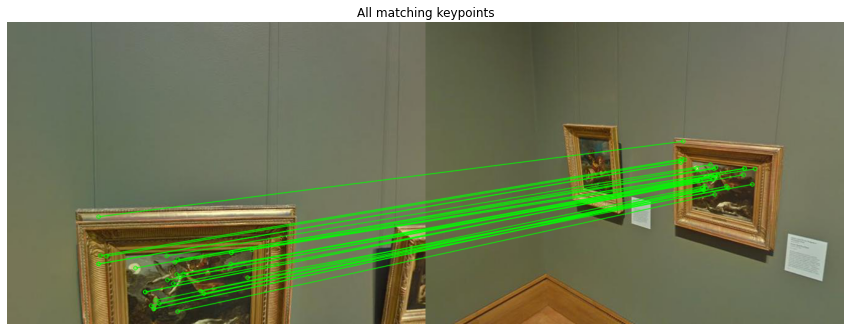

In [26]:
# Show images that predict well: 
count_good = 0
sample_amount = 8
for i in range(0,len(manhattan)):
    if manhattan[i] < 1 and manhattan[i] > 0.3:
        print("The Manhattan distance between ground truth and prediction is {0:.2f} for this image".format(manhattan[i]))
        vali_image_filename = validation_filenames[i]
        vali_image = cv2.imread('COMP90086_2021_Project_train/train/'+vali_image_filename+'.jpg')
        similar_train_image_filename = trainvali_train_filenames[most_similar_indexs[i]]
        similar_image = cv2.imread('COMP90086_2021_Project_train/train/'+similar_train_image_filename+'.jpg')
        if vali_image is not None:
            vali_image = cv2.cvtColor(vali_image, cv2.COLOR_BGR2RGB)
        else:
            continue
        if similar_image is not None:
            similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB) 
        else:
            continue
        # Initiate SIFT detector
        sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
        # sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x 

        # Compute SIFT keypoints and descriptors
        kp1, des1 = sift.detectAndCompute(vali_image,None)
        kp2, des2 = sift.detectAndCompute(similar_image,None)

        # FLANN parameters and initialize
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)

        # Matching descriptor using KNN algorithm
        matches = flann.knnMatch(des1,des2,k=2)

        # Store all good matches as per Lowe's Ratio test.
        ratio = 0.6
        good = []
        for m,n in matches:
            if m.distance < ratio*n.distance:
                good.append(m)

        # Set a condition that at least MIN_MATCH_NUM matches are required to find the object. 
        MIN_MATCH_NUM = 4

        if len(good)> MIN_MATCH_NUM:
            # If enough matches are found, we extract the positions of the matched keypoints in both images. 
            # They are passed to find the perspective transformation. 

            # Estimate homography between two images
            ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
            ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
            H, status = cv2.findHomography(ptsA, 
                                           ptsB, 
                                           cv2.RANSAC, 
                                           ransacReprojThreshold = 5, 
                                           maxIters = 500)

            matchesMask = status.ravel().tolist()
            # Print total number of successful matches between two images
            print("\nNumber of successful matches between two images: ", matchesMask.count(1)) # Returns the number of 1 in the success list

        else:
            # Otherwise, print that “Not enough matches are found”.
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_NUM) )
            matchesMask = None


        # Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
        draw_params = dict(matchColor = (0,255,0), # draw in a specific colour
                           singlePointColor = (255,0,0), # draw in a specific colour
                           matchesMask = matchesMask, # draw only inliers
                           flags = 2)

        success_matches = cv2.drawMatches(vali_image,kp1,similar_image,kp2,good,None,**draw_params)

        # Plotting results
        plt.subplots(figsize=(15, 15)) 

        plt.imshow(success_matches)
        plt.title('All matching keypoints')
        plt.axis('off')
        plt.show()
        count_good += 1
    if count_good >= sample_amount:
        break

The Manhattan distance between ground truth and prediction is 8.60 for this image
Not enough matches are found - 0/4


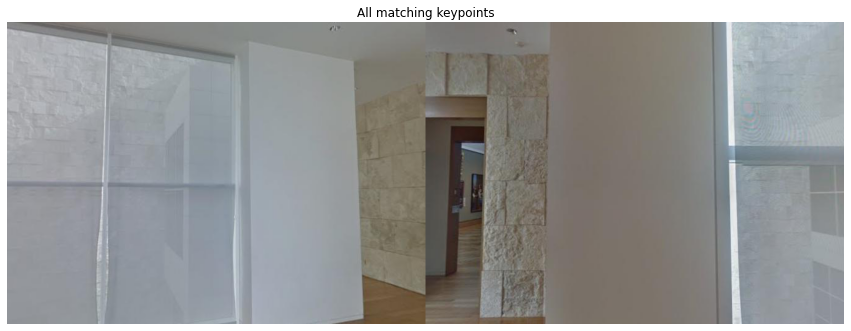

The Manhattan distance between ground truth and prediction is 22.80 for this image

Number of successful matches between two images:  19


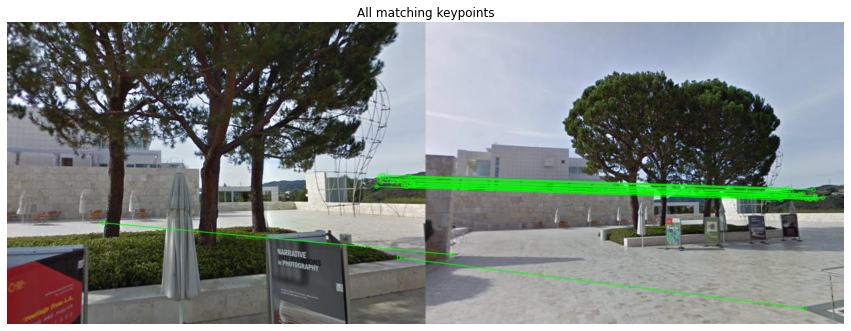

The Manhattan distance between ground truth and prediction is 113.10 for this image

Number of successful matches between two images:  17


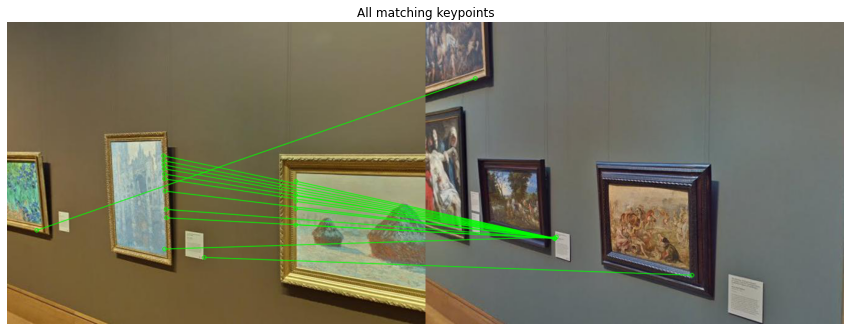

The Manhattan distance between ground truth and prediction is 54.70 for this image

Number of successful matches between two images:  6


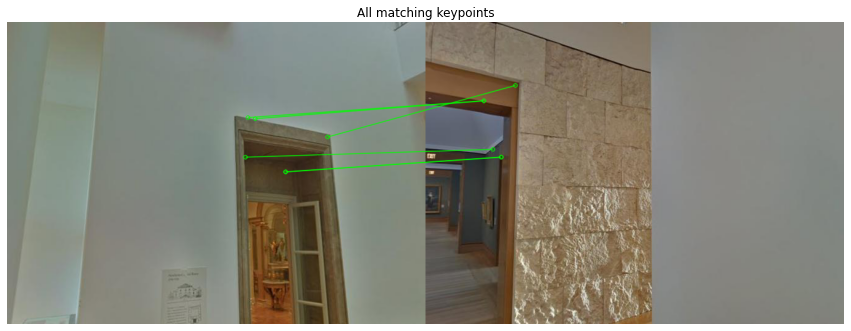

The Manhattan distance between ground truth and prediction is 25.00 for this image

Number of successful matches between two images:  29


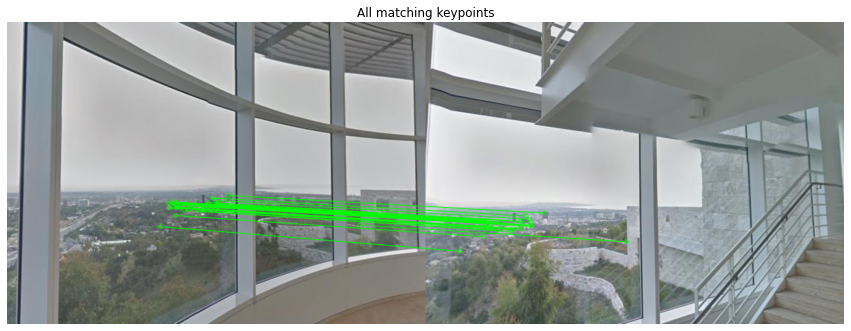

The Manhattan distance between ground truth and prediction is 16.10 for this image

Number of successful matches between two images:  27


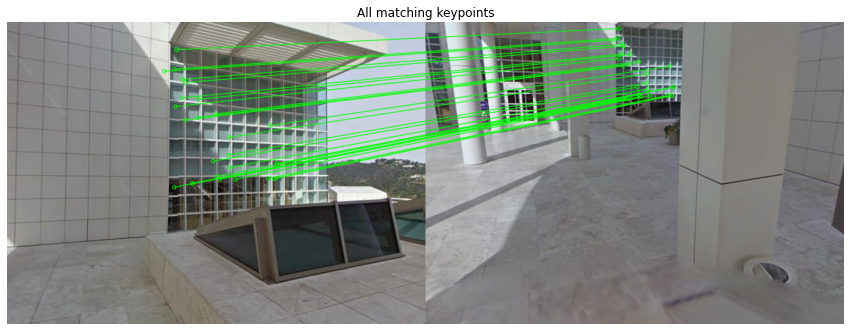

The Manhattan distance between ground truth and prediction is 9.30 for this image

Number of successful matches between two images:  102


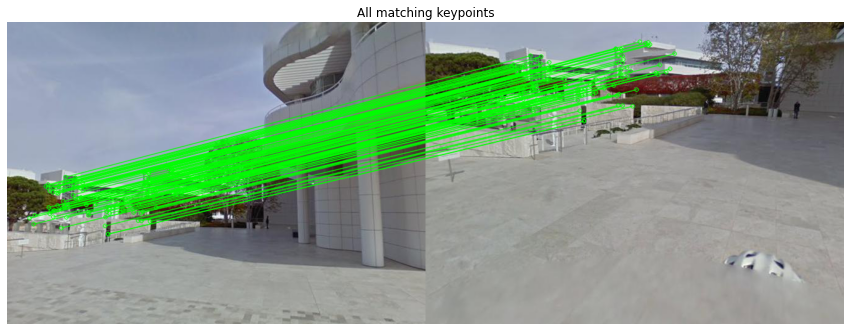

The Manhattan distance between ground truth and prediction is 40.30 for this image

Number of successful matches between two images:  4


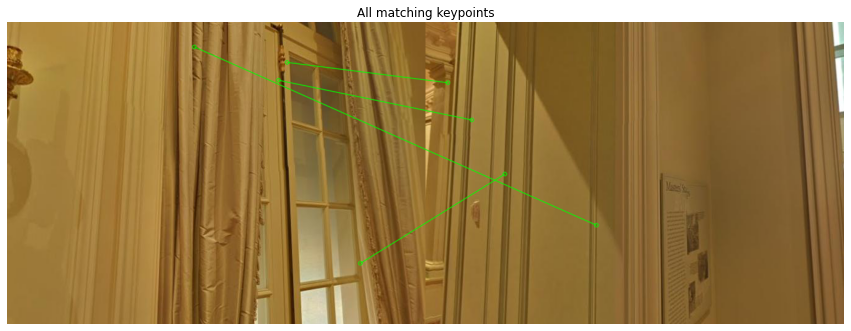

In [30]:
# Show images that predict bad: no prominent features (very zoom into walls, glasses)
count_bad = 0
sample_amount = 8
for i in range(0,len(manhattan)):
    if manhattan[i] > 8:
        print("The Manhattan distance between ground truth and prediction is {0:.2f} for this image".format(manhattan[i]))
        vali_image_filename = validation_filenames[i]
        vali_image = cv2.imread('COMP90086_2021_Project_train/train/'+vali_image_filename+'.jpg')
        similar_train_image_filename = trainvali_train_filenames[most_similar_indexs[i]]
        similar_image = cv2.imread('COMP90086_2021_Project_train/train/'+similar_train_image_filename+'.jpg')
        if vali_image is not None:
            vali_image = cv2.cvtColor(vali_image, cv2.COLOR_BGR2RGB)
        else:
            continue
        if similar_image is not None:
            similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB) 
        else:
            continue
        # Initiate SIFT detector
        sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
        # sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x 

        # Compute SIFT keypoints and descriptors
        kp1, des1 = sift.detectAndCompute(vali_image,None)
        kp2, des2 = sift.detectAndCompute(similar_image,None)

        # vali_image_with_size = cv2.drawKeypoints(vali_image,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        # plt.subplots(figsize=(15, 15)) 
        # plt.imshow(vali_image_with_size)  
        # plt.title('Validation Image keypoints')
        # plt.axis('off')
        # plt.show()
        # FLANN parameters and initialize
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)

        # Matching descriptor using KNN algorithm
        matches = flann.knnMatch(des1,des2,k=2)

        # Store all good matches as per Lowe's Ratio test.
        ratio = 0.6
        good = []
        for m,n in matches:
            if m.distance < ratio*n.distance:
                good.append(m)

        # Set a condition that at least MIN_MATCH_NUM matches are required to find the object. 
        MIN_MATCH_NUM = 4

        if len(good)> MIN_MATCH_NUM:
            # If enough matches are found, we extract the positions of the matched keypoints in both images. 
            # They are passed to find the perspective transformation. 

            # Estimate homography between two images
            ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
            ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
            H, status = cv2.findHomography(ptsA, 
                                           ptsB, 
                                           cv2.RANSAC, 
                                           ransacReprojThreshold = 5, 
                                           maxIters = 500)

            matchesMask = status.ravel().tolist()
            # Print total number of successful matches between two images
            print("\nNumber of successful matches between two images: ", matchesMask.count(1)) # Returns the number of 1 in the success list

        else:
            # Otherwise, print that “Not enough matches are found”.
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_NUM) )
            matchesMask = None


        # Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
        draw_params = dict(matchColor = (0,255,0), # draw in a specific colour
                           singlePointColor = (255,0,0), # draw in a specific colour
                           matchesMask = matchesMask, # draw only inliers
                           flags = 2)

        success_matches = cv2.drawMatches(vali_image,kp1,similar_image,kp2,good,None,**draw_params)

        # Plotting results
        plt.subplots(figsize=(15, 15)) 

        plt.imshow(success_matches)
        plt.title('All matching keypoints')
        plt.axis('off')
        plt.show()
        count_bad += 1
    if count_bad >= sample_amount:
        break

# Attempts on using translation matrix to find further grained location

### Origin train and test images

In [23]:
# Read the most similar 3 images csv
top3similar = pd.read_csv('preprocessed/top3Similar_resnet_featureMatchingRanking_200.csv')
test_filenames = top3similar['id']
similar1 = top3similar['1']
similar2 = top3similar['2']
origin_train_images = np.load('preprocessed/origin_train_images.npy')
origin_test_images = np.load('preprocessed/origin_test_images.npy')

In [72]:
# Use feature detection + matching to calculate transformation matrix for: 
# most similar v.s. test, most similar v.s. second similar
sift = cv2.SIFT_create()
grained_diff = []
tmp_count = 0
for test_image_index in tqdm(range(0,len(test_filenames))):
    test_image = origin_test_images[test_image_index]             
    test_kp, test_des = sift.detectAndCompute(test_image,None)
    # If the test image does not have enough features, just use the top3 similar images decided by extracted features
    if test_des is None or len(test_des)<=3: 
        grained_diff.append((0,0))
        continue
    # The similar image 1
    similar1_image=origin_train_images[similar1[test_image_index]]
    # Compute SIFT keypoints (kp) and descriptors (des) for the similar image
    similar1_kp, similar1_des = sift.detectAndCompute(similar1_image,None)
    if similar1_des is None or len(similar1_des)<=3:
        grained_diff.append((0,0))
        continue
    # The similar image 2
    similar2_image=origin_train_images[similar2[test_image_index]]
    # Compute SIFT keypoints (kp) and descriptors (des) for the similar image
    similar2_kp, similar2_des = sift.detectAndCompute(similar2_image,None)
    if similar2_des is None or len(similar2_des)<=3: 
        grained_diff.append((0,0))
        continue
    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=100)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)

    # Matching similar1 and test images descriptors using KNN algorithm
    matches_1_test = flann.knnMatch(similar1_des,test_des,k=2)

    # Matching similar1 and similar2 images descriptors using KNN algorithm
    matches_1_2 = flann.knnMatch(similar1_des,similar2_des,k=2)
    # Store all good matches as per Lowe's Ratio test for similar 1 and test
    ratio = 0.6
    good_1_test = []
    for m,n in matches_1_test:
        if m.distance < ratio*n.distance:
            good_1_test.append(m)
     # Store all good matches as per Lowe's Ratio test for similar 2 and test
    ratio = 0.6
    good_1_2 = []
    for m,n in matches_1_2:
        if m.distance < ratio*n.distance:
            good_1_2.append(m)

    # Set a condition that at least MIN_MATCH_NUM matches are required to find the object. 
    MIN_MATCH_NUM = 4
    # First calculate the translation matrix for similar1 and test
    translation_1_test = None
    if len(good_1_test)> MIN_MATCH_NUM:
        # If enough matches are found, we extract the positions of the matched keypoints in both images. 
        # They are passed to find the perspective transformation. 

        # Estimate fundamental matrix between two images
        ptsA = np.float32([similar1_kp[m.queryIdx].pt for m in good_1_test]).reshape(-1,1,2)
        ptsB = np.float32([test_kp[m.trainIdx].pt for m in good_1_test]).reshape(-1,1,2)
        fundamental_mat, status = cv2.findFundamentalMat(ptsA, 
                                       ptsB, 
                                       cv2.FM_RANSAC)
        # Where H is the resulting single-strain matrix.
        # status returns a list of feature points that represent successful matches.
        # ptsA, ptsB are keypoints.  
        if status is not None:
            matchesMask = status.ravel().tolist()
            # total number of successful matches between two images
            if matchesMask.count(1) > 12:
                retval, R, t, mask = cv2.recoverPose(fundamental_mat, ptsA, ptsB)
                translation_1_test = t[:2]
    # Then calculate the translation matrix for similar1 and similar2
    translation_1_2 = None
    if len(good_1_2)> MIN_MATCH_NUM:
        # If enough matches are found, we extract the positions of the matched keypoints in both images. 
        # They are passed to find the perspective transformation. 

        # Estimate fundamental matrix between two images
        ptsA = np.float32([similar1_kp[m.queryIdx].pt for m in good_1_2]).reshape(-1,1,2)
        ptsB = np.float32([similar2_kp[m.trainIdx].pt for m in good_1_2]).reshape(-1,1,2)
        fundamental_mat, status = cv2.findFundamentalMat(ptsA, 
                                       ptsB, 
                                       cv2.FM_RANSAC)
        # Where H is the resulting single-strain matrix.
        # status returns a list of feature points that represent successful matches.
        # ptsA, ptsB are keypoints.
        if status is not None:
            matchesMask = status.ravel().tolist()
            # total number of successful matches between two images
            if matchesMask.count(1) > 12:
                retval, R, t, mask = cv2.recoverPose(fundamental_mat, ptsA, ptsB)
                translation_1_2 = t[:2]
    if (translation_1_test is not None and translation_1_2 is not None):
        tmp_count += 1
        # Scale translation matrix to real world distance
        train_csv = pd.read_csv('./COMP90086_2021_Project_train/train.csv')
        real_scale_1 = np.array([train_csv.loc[similar1[test_image_index], 'x'],train_csv.loc[similar1[test_image_index], 'y']])
        real_scale_2 = np.array([train_csv.loc[similar2[test_image_index], 'x'],train_csv.loc[similar2[test_image_index], 'y']])
        real_scale_1_2 = real_scale_2 - real_scale_1
        translation_1_2 = translation_1_2.flatten()
        translation_1_test = translation_1_test.flatten()
        real_scale_1_test_x = real_scale_1_2[0]*translation_1_test[0] / translation_1_2[0]
        real_scale_1_test_y = real_scale_1_2[1]*translation_1_test[1] / translation_1_2[1]
        #real_scale_test =real_scale_1_test + real_scale_1
        if (abs(real_scale_1_test_x) > 10):
            real_scale_1_test_x = 0
        if (abs(real_scale_1_test_y) > 10):
            real_scale_1_test_y = 0
        grained_diff.append((real_scale_1_test_x,real_scale_1_test_y))
    else:
        grained_diff.append((0,0))
print(tmp_count)
assert(len(grained_diff) == len(test_filenames)) # similar1+grained_diff

100%|███████████████████████████████████████| 1200/1200 [05:26<00:00,  3.68it/s]

807


In [71]:
grained_diff_df = pd.DataFrame(grained_diff,columns = ['x_diff','y_diff'])
only_similar_pred = pd.read_csv('./kaggle_submission/resnet_featureMatchingRanking_200.csv')
grained_pred = pd.DataFrame(only_similar_pred['id'],columns=['id'])
grained_pred['x'] = grained_diff_df['x_diff'] + only_similar_pred['x']
grained_pred['y'] = grained_diff_df['y_diff'] + only_similar_pred['y']
grained_pred.to_csv('kaggle_submission/resnet_featureMatching_grained.csv', index=False) 

### Train and validation images

# Old versions of test_train_most_similar

In [ ]:
similar_images_threshold = 3
show_images_similarity_threshold = 27

In [ ]:
def test_train_most_similar(trains_fea,tests_fea,filename,train_csv,test_csv,overwrite = False, show=False,store_similar=False):
    # The most similar images indexes 
    # This is for initial baseline submission (use the most similar image location for prediction)
    most_similar_indexes = []
    text_image_index = 0
    # The top 3 similar images indexes
    # This is for later on further processing (such as SIFT)
    top3_similar_indexes = []
    # For each test image's extracted feature, calculate the similarities between it and each train images
    # Store the most similar X images
    for test_fea in tests_fea:
        similarities = []
        # The similarities between test_fea and each train_fea
        for train_fea in trains_fea:
            similarity = np.linalg.norm(test_fea-train_fea)
            similarities.append(similarity)
        similarities = np.asarray(similarities)
        # Most 3 similar ones
        top3_similar_index = similarities.argsort()[:similar_images_threshold]
        top3_similar_indexes.append(top3_similar_index)
        # Most similar ones
        most_similar_indexes.append(np.argmin(similarities))
        if (show):
            if(np.min(similarities)>show_images_similarity_threshold):
                show_top_similar_images(text_image_index,similarities, origin_test_images=origin_test_images,origin_train_images=origin_train_images)
        text_image_index += 1
    most_similar_indexes = np.asarray(most_similar_indexes)
    # Overwrite decides whether store/overwrite the previous csv file
    if store_similar:
        top3_similar_indexes = pd.DataFrame(top3_similar_indexes, columns=["0", "1","2"])
        test_similar = pd.concat([test_csv, top3_similar_indexes], axis=1)
        test_similar.to_csv('preprocessed/test_most_3_similars.csv', index=False) 
    # Overwrite decides whether overwrite the previous predictions
    if overwrite:
        test_xy_estimations = []
        for i in range (len(tests_fea)):
            train_target_index = most_similar_indexes[i]
            test_xy_estimations.append((train_csv.loc[train_target_index, 'x'],train_csv.loc[train_target_index, 'y']))
        test_xy_estimations = pd.DataFrame(test_xy_estimations, columns=["x", "y"])
        test_estimations = pd.concat([test_csv, test_xy_estimations], axis=1)
        test_estimations.to_csv('kaggle_submission/'+filename+'.csv', index=False) 

In [ ]:
# Show most X(e.g. 3) similar images from training dataset with the given test image
def show_top_similar_images(test_image_index,train_similarities,top = 3,origin_test_images=None, origin_train_images=None):
    # Load original files
    if (origin_test_images is None) or (origin_train_images is None):
        origin_train_images = np.load('preprocessed/origin_train_images.npy')
        origin_test_images = np.load('preprocessed/origin_test_images.npy')
    # Test image
    test_image = origin_test_images[test_image_index]
    plt.figure()
    plt.axis('off')
    plt.imshow(test_image)
    # Most similar train images indexes
    top_similar_images_indexes = train_similarities.argsort()[:top]
    # Plot similar images
    for similar_image_index in top_similar_images_indexes:
        similar_image = origin_train_images[similar_image_index]
        plt.figure()
        plt.axis('off')
        plt.imshow(similar_image)

In [ ]:
'''
Version 2 of finding the most similar image: Using feature matching (SIFT+FLANN) to 
validate the most similar image determined by extracted features is the real most similar
(i.e. having at least 8 matching features)
Otherwise, compare to the second most similar and so on
'''

def test_train_most_similar_v2(trains_fea,tests_fea,filename,train_csv,test_csv,origin_train_images,origin_test_images):
    sift = cv2.SIFT_create()
    # The most similar images indexes 
    # This is for initial baseline submission (use the most similar image location for prediction)
    most_similar_indexes = []
    # For each test image's extracted feature, calculate the similarities between it and each train images
    # Store the most similar X images
    for text_image_index in tqdm(range(0,len(tests_fea))):
        found_true_similar = False
        test_fea = tests_fea[text_image_index]
          
        similarities = []
        # The similarities between test_fea and each train_fea
        for train_fea in trains_fea:
            similarity = np.linalg.norm(test_fea-train_fea)
            similarities.append(similarity)
        # Sort the similar images in order, get the sorted index 
        similar_indexes_inorder = sorted(range(len(similarities)), key=lambda k: similarities[k])
        # Compute SIFT keypoints (kp) and descriptors (des) for the test image
        test_image = origin_test_images[text_image_index]             
        test_kp, test_des = sift.detectAndCompute(test_image,None)
        # If not enough features are found in the test image, use the most similar image determined by extracted features
        if test_des is None or len(test_des)<=3: 
            most_similar_indexes.append(similar_indexes_inorder[0])
            continue
        topThreshold = 200
        similar_count = 0
        for similar_train_index in similar_indexes_inorder: # Similar images in order
            # only check top 200 most similar images 
            if similar_count > topThreshold:
                break
            similar_count += 1
            # The similar image
            similar_image=origin_train_images[similar_train_index]
            # Compute SIFT keypoints (kp) and descriptors (des) for the similar image
            similar_kp, similar_des = sift.detectAndCompute(similar_image,None)
            # If not enough features are found in the train image, skip this one
            if similar_des is None or len(similar_des)<=3: 
                continue
            # FLANN parameters and initialize
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks=100)   # or pass empty dictionary
            flann = cv2.FlannBasedMatcher(index_params,search_params)

            # Matching test and similar images descriptors using KNN algorithm
            matches = flann.knnMatch(test_des,similar_des,k=2)

            # Store all good matches as per Lowe's Ratio test.
            ratio = 0.6
            good = []
            for m,n in matches:
                if m.distance < ratio*n.distance:
                    good.append(m)

            # Set a condition that at least MIN_MATCH_NUM matches are required to find the object. 
            MIN_MATCH_NUM = 4

            if len(good)> MIN_MATCH_NUM:
                # If enough matches are found, we extract the positions of the matched keypoints in both images. 
                # They are passed to find the perspective transformation. 

                # Estimate homography between two images
                ptsA = np.float32([test_kp[m.queryIdx].pt for m in good]).reshape(-1,1,2)
                ptsB = np.float32([similar_kp[m.trainIdx].pt for m in good]).reshape(-1,1,2)
                H, status = cv2.findHomography(ptsA, 
                                               ptsB, 
                                               cv2.RANSAC, 
                                               ransacReprojThreshold = 5, 
                                               maxIters = 500)
                # Where H is the resulting single-strain matrix.
                # status returns a list of feature points that represent successful matches.
                # ptsA, ptsB are keypoints.   

                matchesMask = status.ravel().tolist()
                # total number of successful matches between two images
                success_match = matchesMask.count(1)
                # Check if the number of successful matches is greater than a preset threshold
                # to validate the similar image found with extracted features
                if success_match > 8:
                    most_similar_indexes.append(similar_train_index)
                    found_true_similar = True
                    break  
        # If non of top 200 similar images pass the validation, just use the most similar image
        if not found_true_similar:
            most_similar_indexes.append(similar_indexes_inorder[0])
        assert(len(most_similar_indexes) == text_image_index+1) 
    # Most similar image indexes for 1200 test images
    most_similar_indexes = np.asarray(most_similar_indexes)
    # Directly use the location of the most similar image
    test_xy_estimations = []
    for i in range (len(tests_fea)):
        train_target_index = most_similar_indexes[i]
        test_xy_estimations.append((train_csv.loc[train_target_index, 'x'],train_csv.loc[train_target_index, 'y']))
    test_xy_estimations = pd.DataFrame(test_xy_estimations, columns=["x", "y"])
    test_estimations = pd.concat([test_csv, test_xy_estimations], axis=1)
    test_estimations.to_csv('kaggle_submission/'+filename+'.csv', index=False) 
